#Group 5 Members:
- Jacky
- Savina
- Bryan
- Nicky

##Project: LightGBM Modern Algorithm

## Project Overview: Comparing ML Models on Porto Seguro Driver Data

This project explores how different tree-based machine learning models perform when trying to predict whether a car insurance customer will file a claim next year. The dataset comes from **Kaggle's Porto Seguro’s Safe Driver Prediction** challenge.

* `0` → no insurance claim made
* `1` → insurance claim was made

We’re trying to **predict the probability** of someone making a claim based on their profile.

## Models Compared

Three popular (and fairly different) tree-based models:

### 1. Decision Tree

* Basic model, quick and interpretable.
* Tends to **overfit** and usually doesn't do well on more complex patterns.

### 2. Random Forest

* Takes decision trees and averages them out.
* Helps reduce overfitting and gives more stable results than a single tree.
* Can be slow depending on number of trees or the dataset is big.

### 3. LightGBM (Light Gradient Boosting Machine)

* Newer and very efficient gradient boosting framework from Microsoft.
* Known for **speed and accuracy**, especially when you’re dealing with a ton of features or big datasets.
* Slightly more difficult to tune.

## Metrics

### AUC (Area Under the ROC Curve)

* AUC tells me how well the model separates claimers vs. non-claimers.
* Good for **imbalanced datasets**, which this one definitely is.
* **Higher is better**. A perfect model would get 1.0

### Training Time (in seconds)

* How long each model takes to train.
* It helps to understand how scalable or efficient the model is

## Main Goal

* Which model is **most accurate** (i.e., has the highest AUC)?
* Which one is the **fastest** to train?
* How do they each behave when the dataset gets bigger?
* Is LightGBM the best when compared to older methods?



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the training and test datasets from Google Drive
train = pd.read_csv("/content/drive/MyDrive/content/porto-seguro-safe-driver-prediction/train.csv")
test = pd.read_csv("/content/drive/MyDrive/content/porto-seguro-safe-driver-prediction/test.csv")

# NOTE: experimented with downsampling earlier — might bring this back later if training ia too slow
# train = train.sample(frac=0.5, random_state=42)  # randomly keep 50% of training data
# test = test.sample(frac=0.5, random_state=42)    # same for test data

# Check on the shape — just to see what we're working with
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (595212, 59)
Test shape: (892816, 58)


In [4]:
print(train.head())
print(train.info())

   id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ...  \
0              0              0              1              0  ...   
1              0              0              0              1  ...   
2              0              0              0              1  ...   
3              0              1              0              0  ...   
4              0              1              0              0  ...   

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           9           1           5           8               0   
1           3           1 

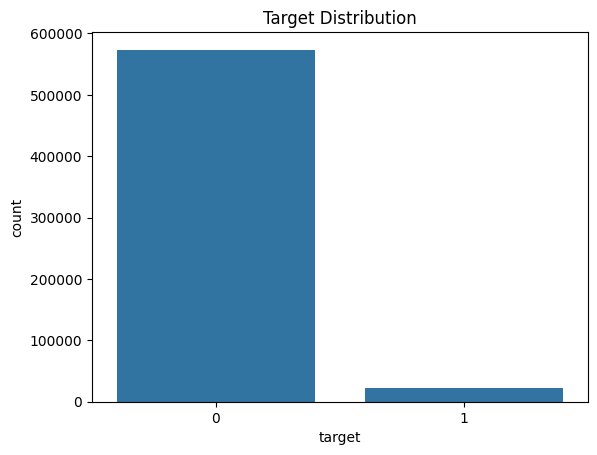

,proportion
target,
0,0.963552
1,0.036448


In [5]:
sns.countplot(data=train, x='target')
plt.title("Target Distribution")
plt.show()

train['target'].value_counts(normalize=True)

We can see that the data is very skewed in the target column, so for accuracy we will be using the ROC AUC curve.

In [6]:
train_missing = train.isnull().sum().sort_values(ascending=False)
print("Missing Values:", train_missing[train_missing > 0].size)
(train == -1).sum().sort_values(ascending=False).head(20)

Missing Values: 0


,0
ps_car_03_cat,411231
ps_car_05_cat,266551
ps_reg_03,107772
ps_car_14,42620
ps_car_07_cat,11489
ps_ind_05_cat,5809
ps_car_09_cat,569
ps_ind_02_cat,216
ps_car_01_cat,107
ps_ind_04_cat,83


There are no null values, but it seems like missing values are being recorded as -1.

In [7]:
bin_features  = [c for c in train.columns if '_bin' in c]
cat_features  = [c for c in train.columns if '_cat' in c]
calc_features = [c for c in train.columns if 'ps_calc_' in c and '_bin' not in c]
reg_features  = [c for c in train.columns if 'ps_reg_' in c]
car_features  = [c for c in train.columns if 'ps_car_' in c and '_cat' not in c]
ind_features  = [c for c in train.columns if 'ps_ind_' in c and '_bin' not in c and '_cat' not in c]

print("Binary features:", bin_features)
print("Categorical features:", cat_features)
print("Car features (continuous):", car_features)
print("Regression features:", reg_features)
print("Individual features:", ind_features)
print("Calculated features:", calc_features)


print("Binary Features:")
print(bin_features, "\n")

print("Categorical Features:")
print(cat_features, "\n")

print("Calculated Features:")
print(calc_features, "\n")

print("Regression/Continuous Features:")
print(reg_features, "\n")

print("Other Individual Features (non-binary, non-categorical):")
print(ind_features)
continuous_features = reg_features + car_features + ind_features

Binary features: ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
Categorical features: ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
Car features (continuous): ['ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']
Regression features: ['ps_reg_01', 'ps_reg_02', 'ps_reg_03']
Individual features: ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15']
Calculated features: ['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc

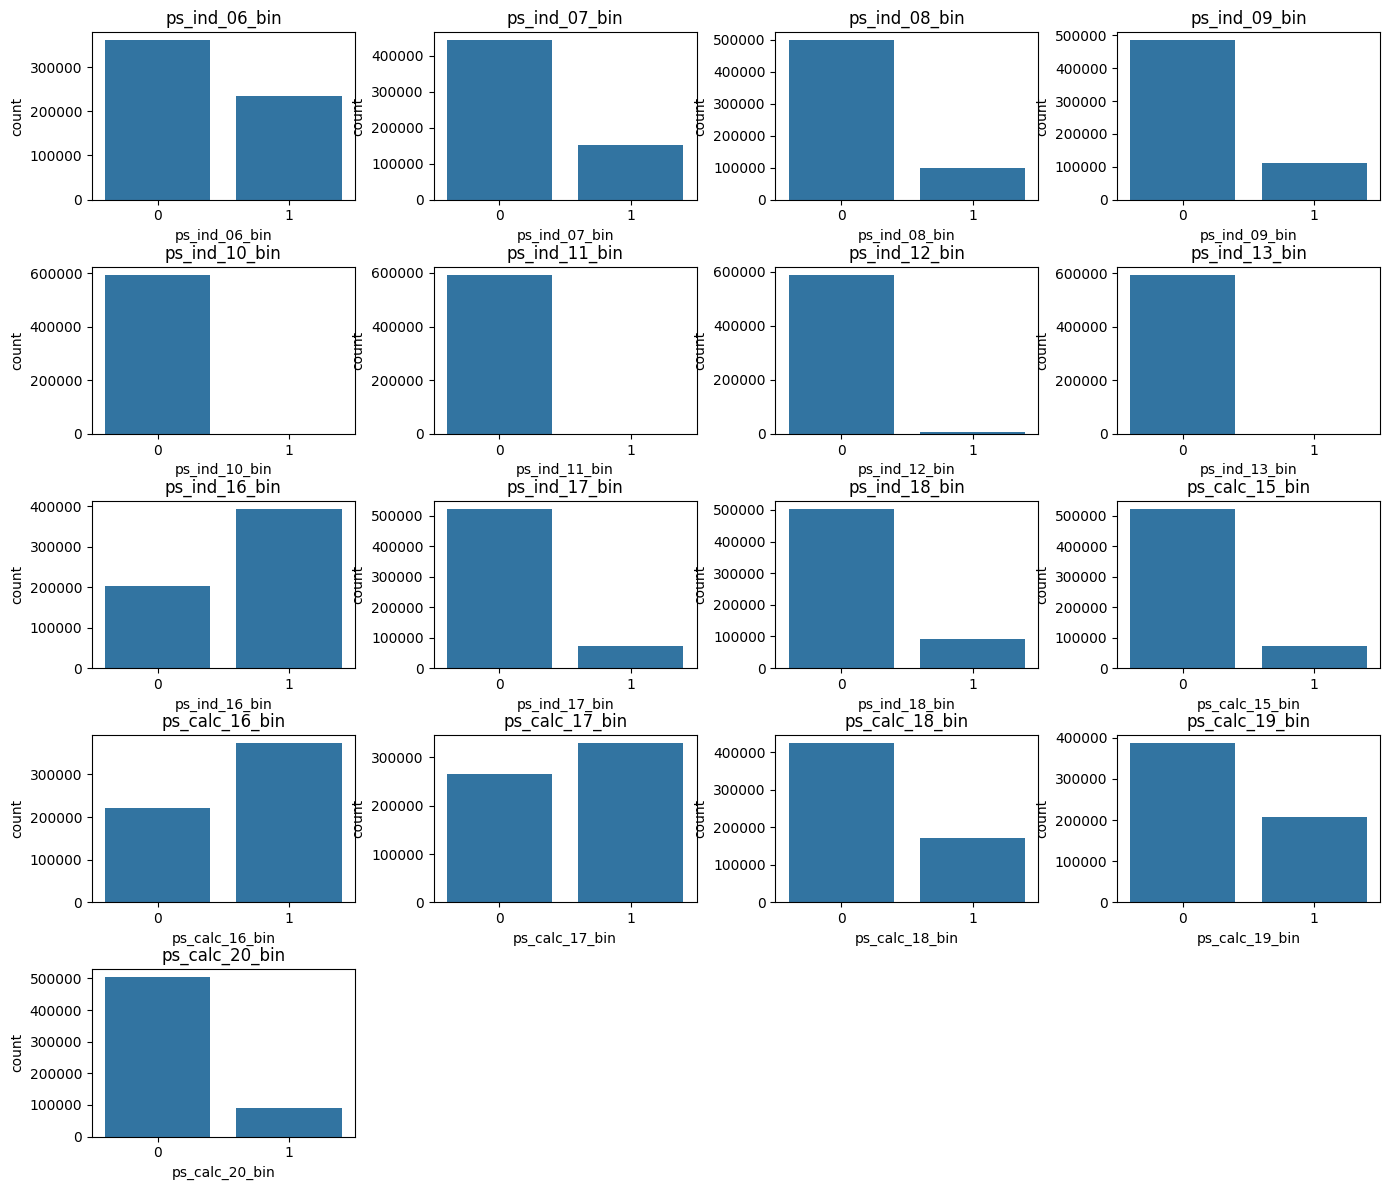

In [8]:
# Binary Features
plt.figure(figsize=(14, 12))
for i, col in enumerate(bin_features):
    plt.subplot((len(bin_features)//4)+1, 4, i+1)
    sns.countplot(x=train[col])
    plt.title(col)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()



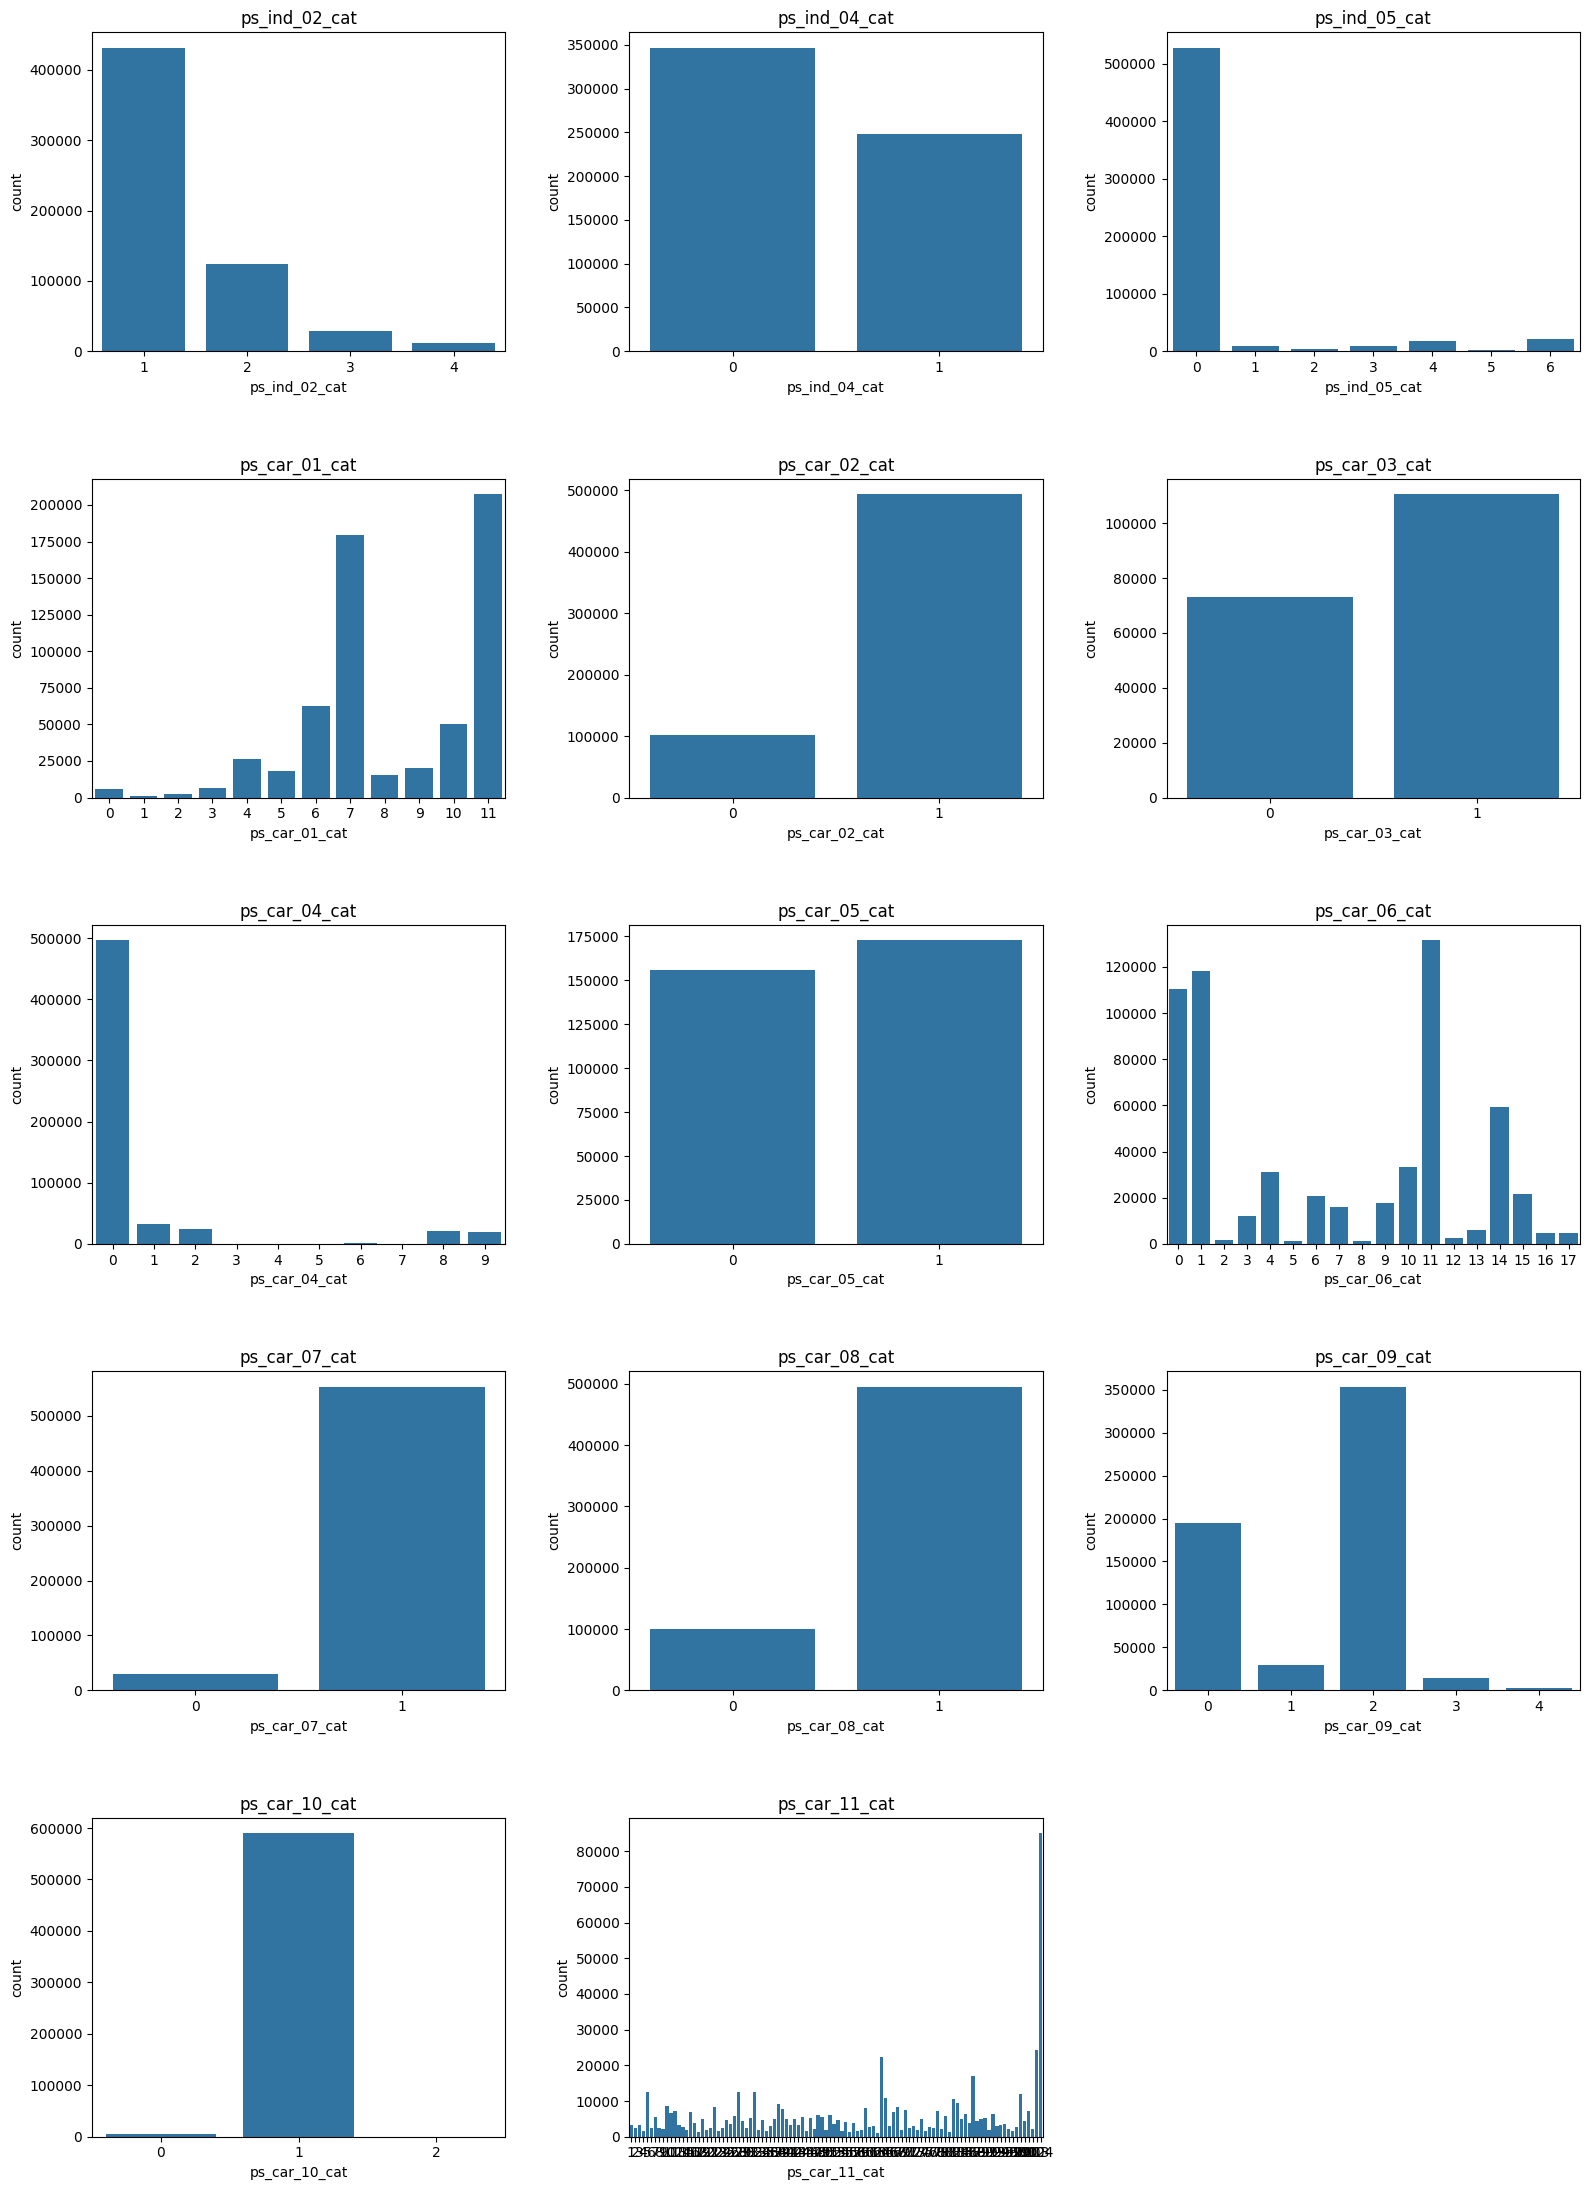

In [9]:
# Categorical features
plt.figure(figsize=(16, 22))
for i, col in enumerate(cat_features):
    plt.subplot((len(cat_features)//3)+1, 3, i+1)
    sns.countplot(x=train[train[col] != -1][col])  # ignore -1
    plt.title(col)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

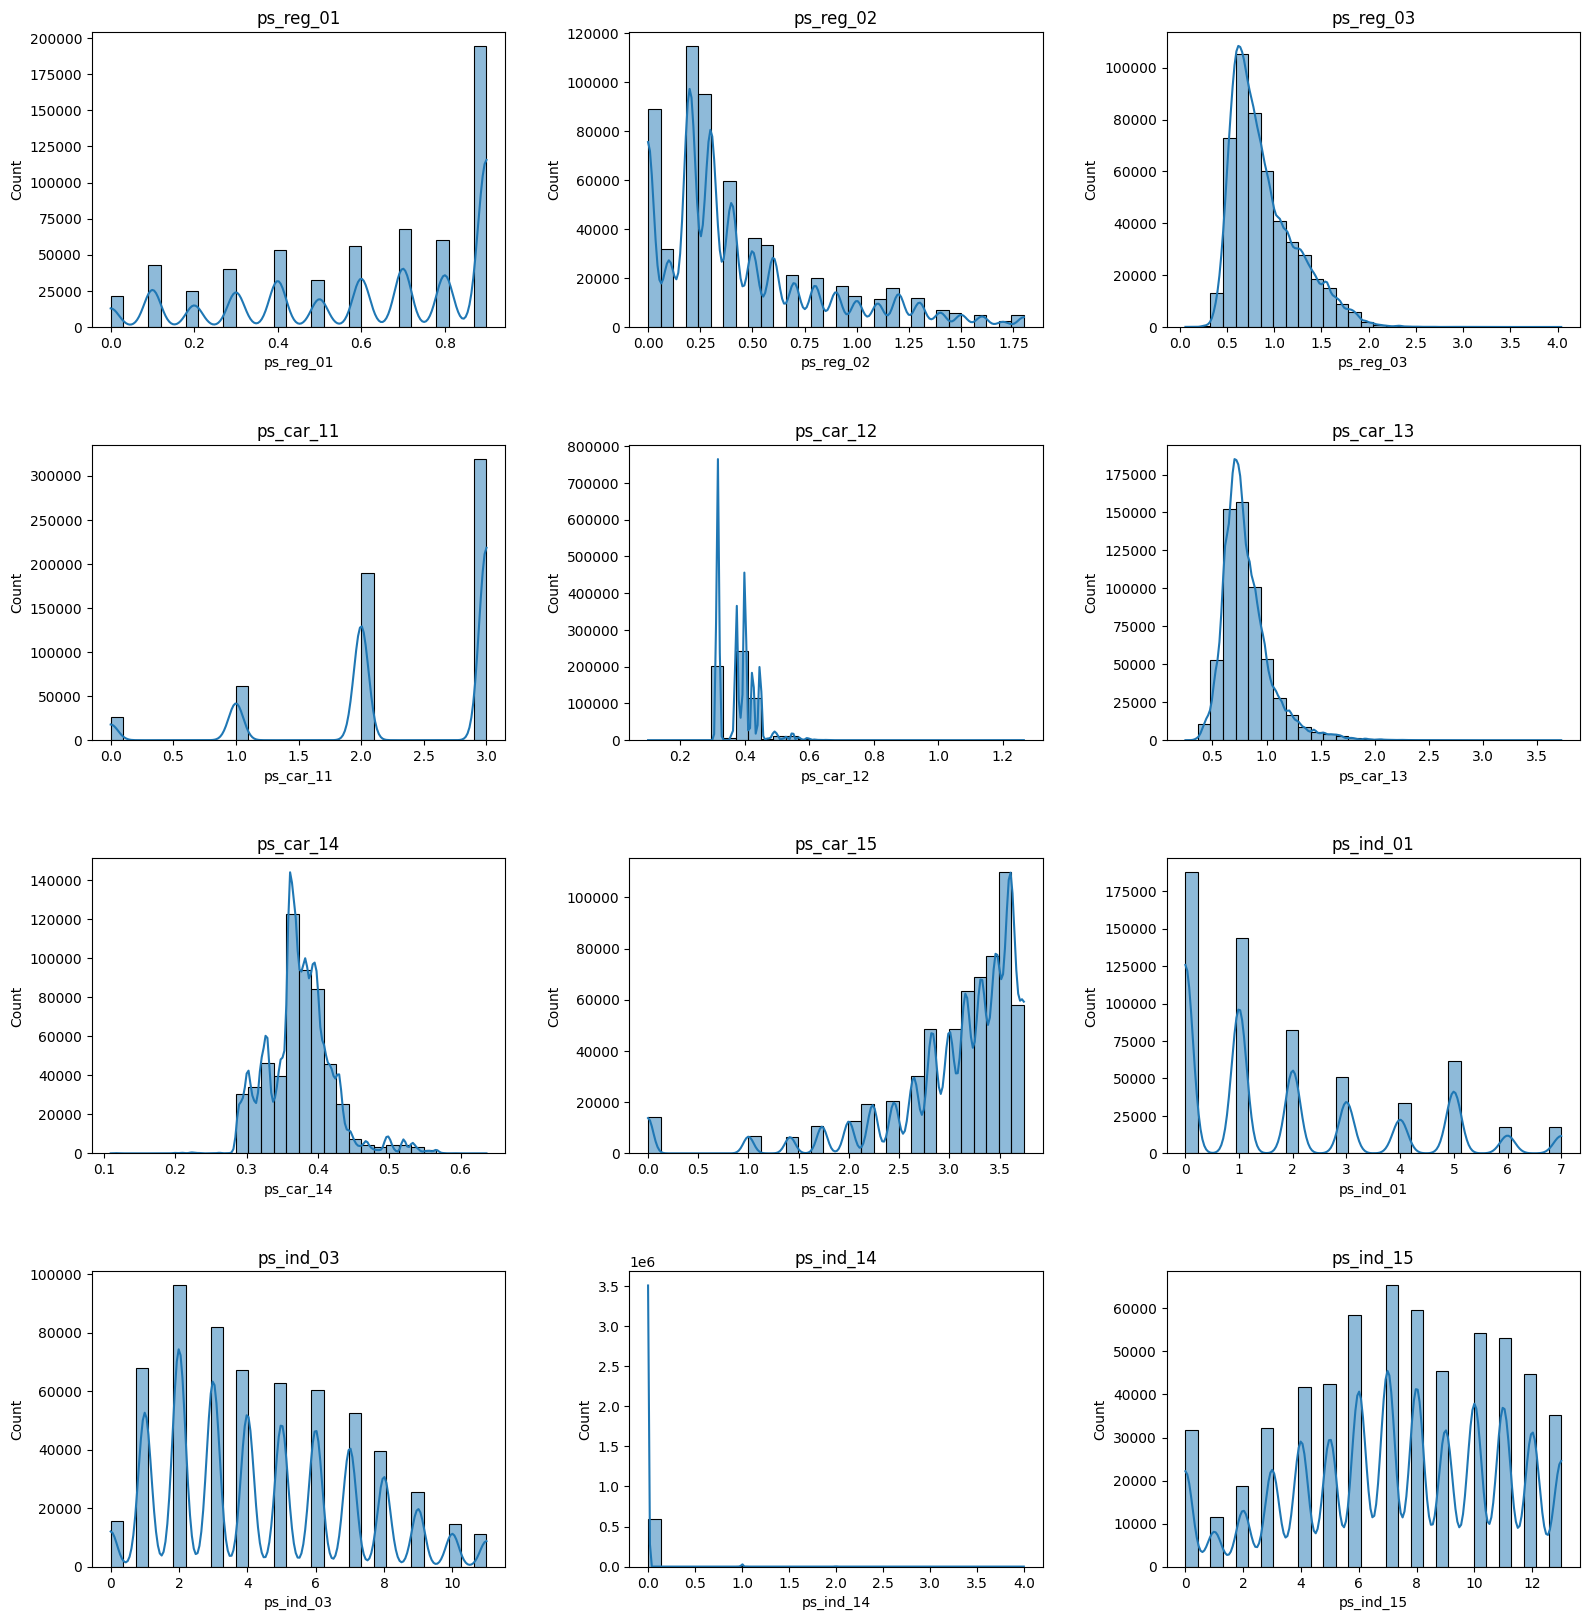

In [10]:
# Continuous Features
plt.figure(figsize=(16, 20))
for i, col in enumerate(continuous_features):
    plt.subplot((len(continuous_features)//3)+1, 3, i+1)
    sns.histplot(train[train[col] != -1][col], bins=30, kde=True)  # ignore -1
    plt.title(col)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

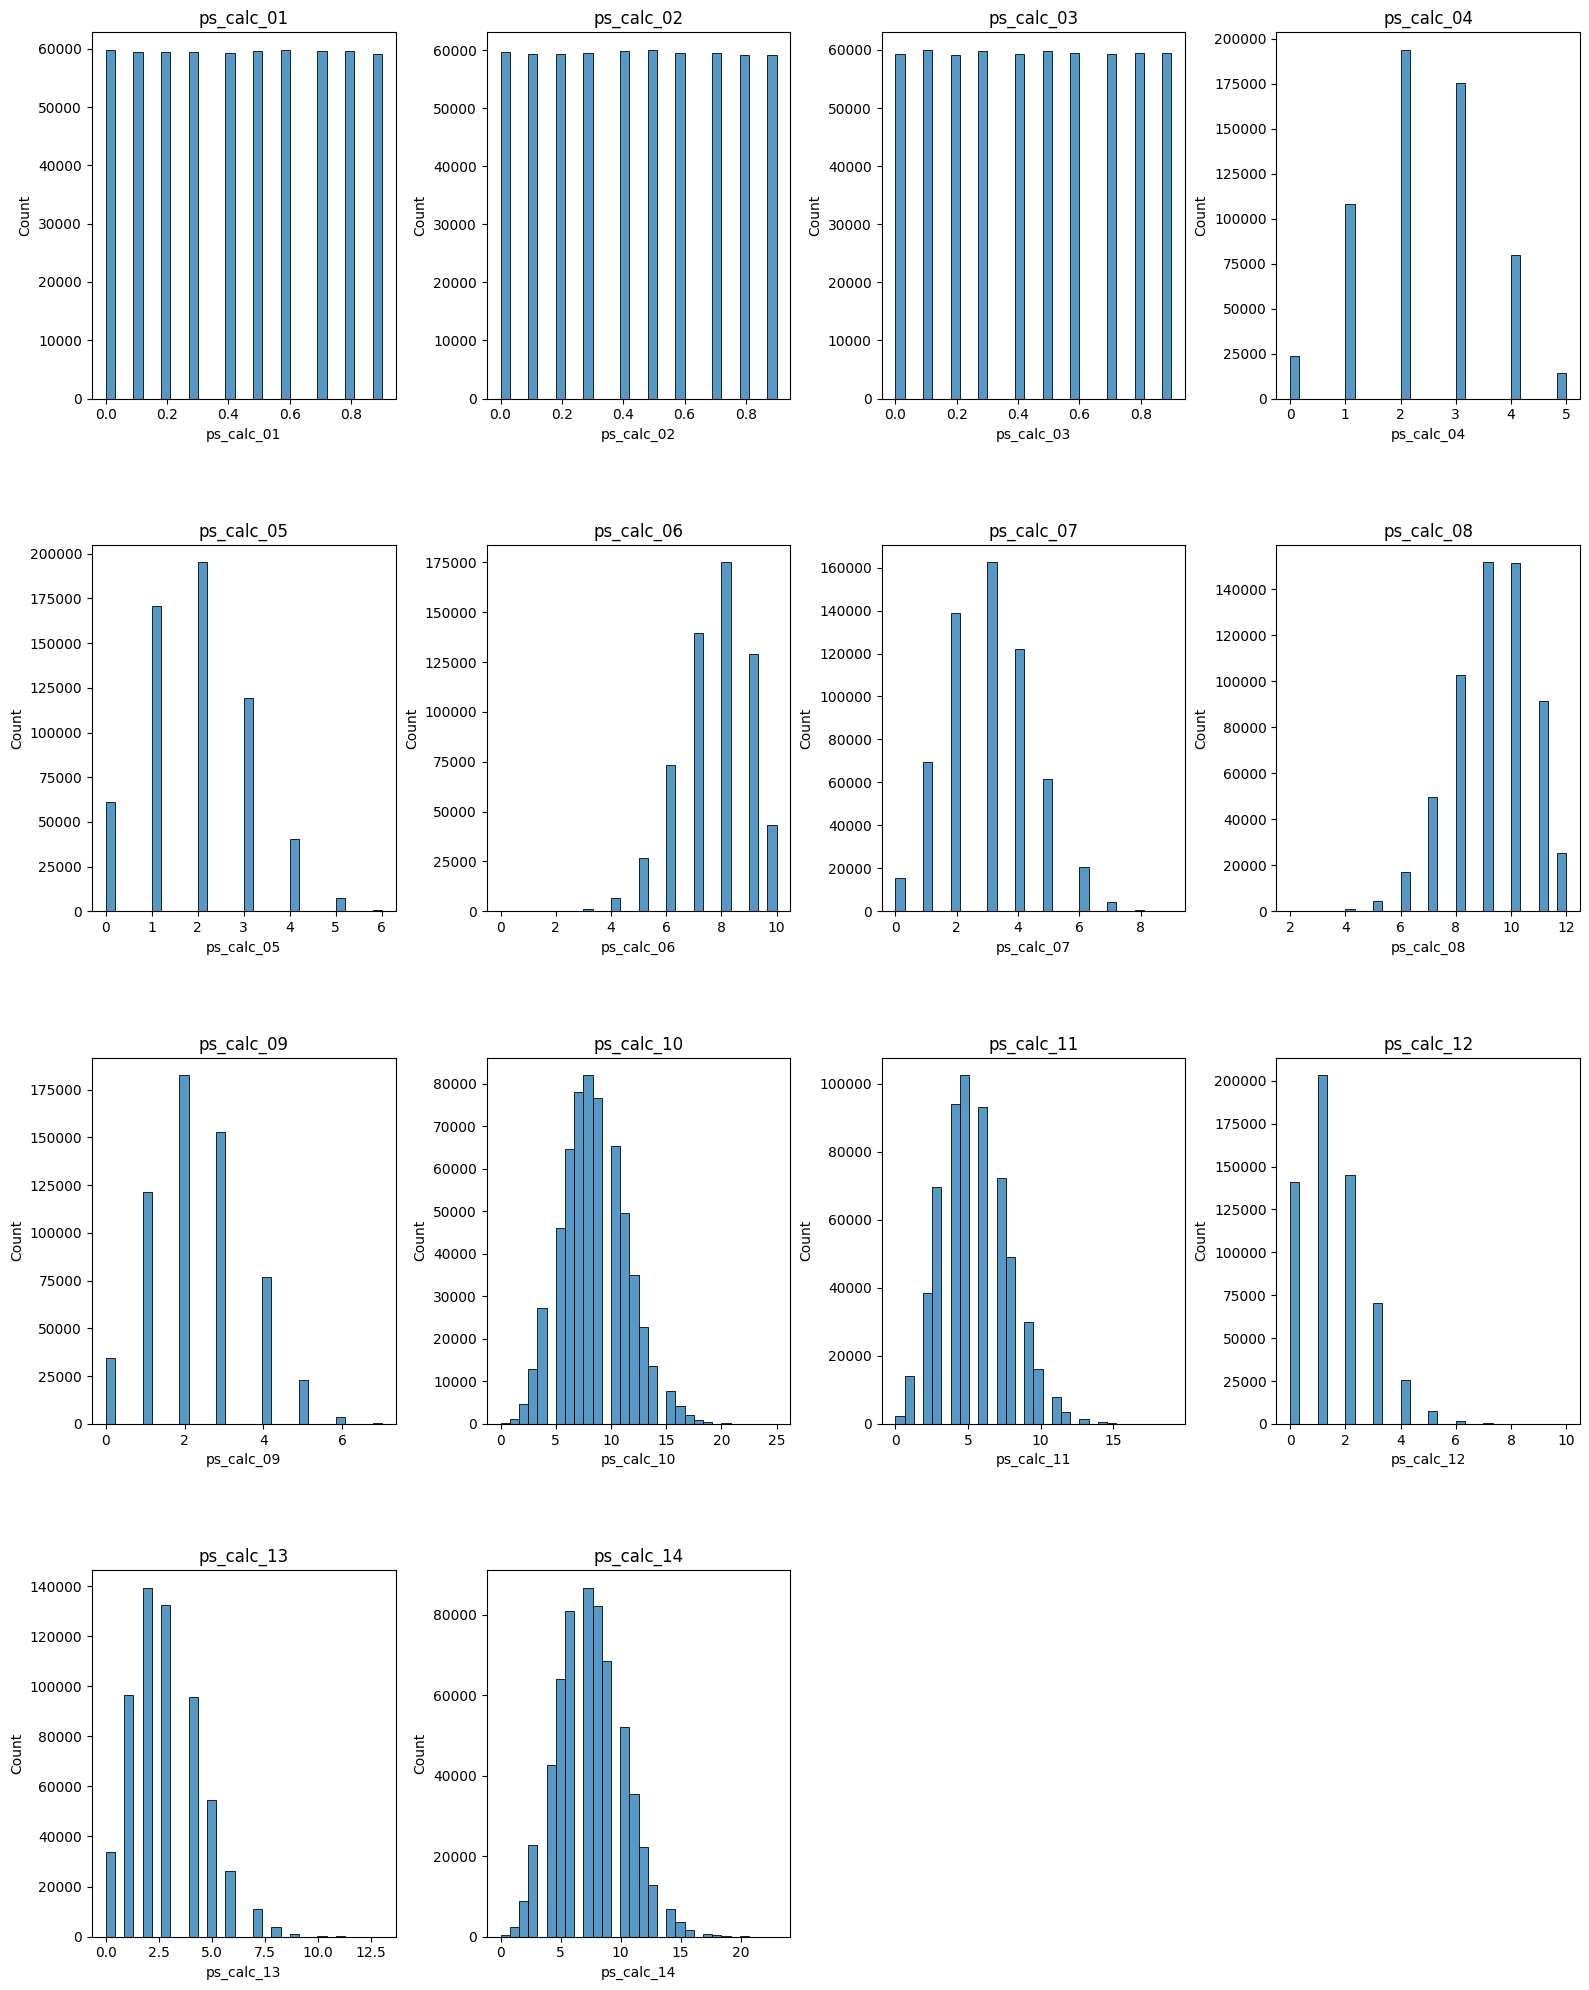

In [11]:
# Calculated Features
plt.figure(figsize=(16, 20))
for i, col in enumerate(calc_features):
    plt.subplot((len(calc_features)//4)+1, 4, i+1)
    sns.histplot(train[train[col] != -1][col], bins=30)
    plt.title(col)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import time

In [13]:
# Preprocessing
def preprocess_porto(train_df, test_df, drop_calc=True, for_logreg=False):
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Separate target
    y = train_df['target']
    train_df.drop(['target'], axis=1, inplace=True)

    # Drop calculated features
    if drop_calc:
        train_df.drop(calc_features, axis=1, inplace=True)
        test_df.drop(calc_features, axis=1, inplace=True)

    # Categorical: keep -1 as category
    for col in cat_features:
        if col in train_df.columns:  # skip if calc features removed
            train_df[col] = train_df[col].astype('category')
            test_df[col]  = test_df[col].astype('category')

    # Continuous: replace -1 with median + missing indicator
    cont_feats = [c for c in continuous_features if c in train_df.columns]
    for col in cont_feats:
        train_df[col] = train_df[col].replace(-1, np.nan)
        test_df[col]  = test_df[col].replace(-1, np.nan)
        train_df[col + '_missing'] = train_df[col].isna().astype(int)
        test_df[col + '_missing']  = test_df[col].isna().astype(int)
        median = train_df[col].median()
        train_df[col] = train_df[col].fillna(median)
        test_df[col]  = test_df[col].fillna(median)

    # One-hot encode categorical for logistic regression
    if for_logreg:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        combined = pd.concat([train_df[cat_features], test_df[cat_features]])
        ohe.fit(combined)

        train_ohe = pd.DataFrame(ohe.transform(train_df[cat_features]),
                                 columns=ohe.get_feature_names_out(cat_features),
                                 index=train_df.index)
        test_ohe  = pd.DataFrame(ohe.transform(test_df[cat_features]),
                                 columns=ohe.get_feature_names_out(cat_features),
                                 index=test_df.index)

        train_df = pd.concat([train_df.drop(cat_features, axis=1), train_ohe], axis=1)
        test_df  = pd.concat([test_df.drop(cat_features, axis=1), test_ohe], axis=1)

    return train_df, y, test_df

X_proc, y, X_test_proc = preprocess_porto(train, test, drop_calc=True, for_logreg=False)
X_train, X_val, y_train, y_val = train_test_split(
    X_proc, y, test_size= 0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_lr = X_train.copy()
X_val_lr   = X_val.copy()

cont_feats = [c for c in continuous_features if c in X_train_lr.columns]
X_train_lr[cont_feats] = scaler.fit_transform(X_train_lr[cont_feats])
X_val_lr[cont_feats]   = scaler.transform(X_val_lr[cont_feats])

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
results = {}

Train set shape: (476169, 56) (476169,)
Validation set shape: (119043, 56) (119043,)


In [14]:
start = time.time()
lr = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
lr.fit(X_train_lr, y_train)
y_pred_lr = lr.predict_proba(X_val_lr)[:, 1]
end = time.time()
results['Logistic Regression'] = {'AUC': roc_auc_score(y_val, y_pred_lr), 'Time(s)': end - start}

In [15]:
start = time.time()
dt = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict_proba(X_val)[:, 1]
end = time.time()
results['Decision Tree'] = {'AUC': roc_auc_score(y_val, y_pred_dt), 'Time(s)': end - start}

In [16]:
start = time.time()
rf = RandomForestClassifier(n_estimators=200, max_depth=8, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_val)[:, 1]
end = time.time()
results['Random Forest'] = {'AUC': roc_auc_score(y_val, y_pred_rf), 'Time(s)': end - start}

In [17]:
start = time.time()
categorical_feats_lgb = [c for c in X_train.columns if '_cat' in c or '_bin' in c]
lgb_train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feats_lgb)
lgb_val_data   = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data, categorical_feature=categorical_feats_lgb)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

lgb_model = lgb.train(params, lgb_train_data, num_boost_round=500,
                      valid_sets=[lgb_train_data, lgb_val_data])

y_pred_lgb = lgb_model.predict(X_val)
end = time.time()
results['LightGBM'] = {'AUC': roc_auc_score(y_val, y_pred_lgb), 'Time(s)': end - start}

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1464
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764


In [18]:
for model, res in results.items():
    print(f"{model} → AUC: {res['AUC']:.4f}, Time: {res['Time(s)']:.2f}s")

Logistic Regression → AUC: 0.6202, Time: 93.23s
Decision Tree → AUC: 0.6010, Time: 5.23s
Random Forest → AUC: 0.6285, Time: 133.52s
LightGBM → AUC: 0.6329, Time: 88.89s


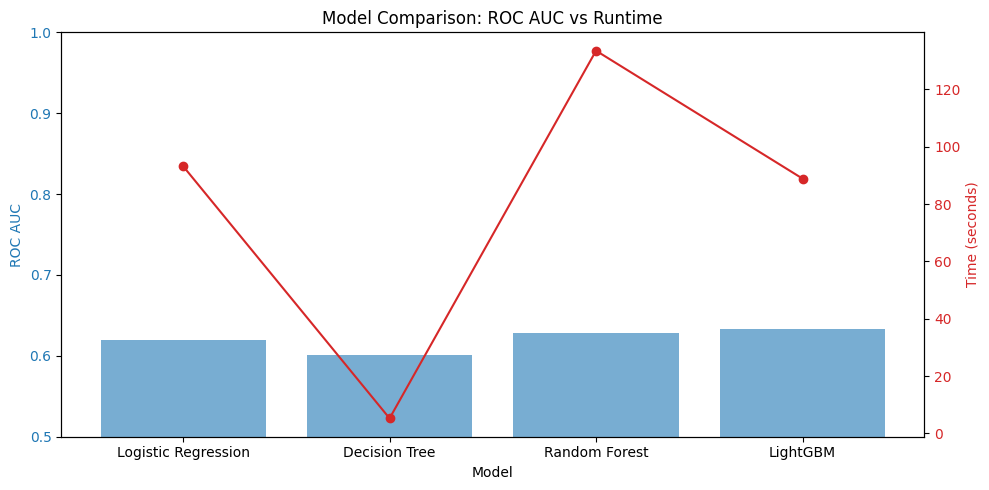

In [19]:
models = list(results.keys())
aucs = [results[m]['AUC'] for m in models]
times = [results[m]['Time(s)'] for m in models]

# Set figure size
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot AUC
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('ROC AUC', color=color)
ax1.bar(models, aucs, color=color, alpha=0.6, label='AUC')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.5, 1.0)

# Plot runtime on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(models, times, color=color, marker='o', label='Time (s)')
ax2.set_ylabel('Time (seconds)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add title
plt.title('Model Comparison: ROC AUC vs Runtime')
fig.tight_layout()
plt.show()

In [20]:
# ========= GENERATE KAGGLE SUBMISSIONS FOR ALL MODELS ========= #

def make_submission(model, model_name, X_test, test_df):
    """
    Generate a Kaggle submission CSV for any model.
    """
    print(f"Generating submission for {model_name}...")

    # Use predict_proba if available
    if hasattr(model, "predict_proba"):
        preds = model.predict_proba(X_test)[:, 1]
    else:
        preds = model.predict(X_test)

    submission = pd.DataFrame({
        'id': test_df['id'],
        'target': preds
    })

    filename = f"submission_{model_name}.csv"
    submission.to_csv(filename, index=False)

    print(f"Saved: {filename}\n")


# ---------- Logistic Regression (uses scaled test set) ----------
# You MUST preprocess the test set the same way you did X_train_lr / X_val_lr
X_test_lr = X_test_proc.copy()
X_test_lr[cont_feats] = scaler.transform(X_test_lr[cont_feats])

make_submission(lr, "logistic_regression", X_test_lr, test)

# ---------- Decision Tree ----------
make_submission(dt, "decision_tree", X_test_proc, test)

# ---------- Random Forest ----------
make_submission(rf, "random_forest", X_test_proc, test)

# ---------- LightGBM ----------
make_submission(lgb_model, "lightgbm", X_test_proc, test)


Generating submission for logistic_regression...
Saved: submission_logistic_regression.csv

Generating submission for decision_tree...
Saved: submission_decision_tree.csv

Generating submission for random_forest...
Saved: submission_random_forest.csv

Generating submission for lightgbm...
Saved: submission_lightgbm.csv



In [21]:
from google.colab import files
files.download("submission_logistic_regression.csv")
files.download("submission_decision_tree.csv")
files.download("submission_random_forest.csv")
files.download("submission_lightgbm.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>